In [3]:
import os
import sys
path_to_this_notebook = os.path.abspath('.')
PATH_TO_PROJECT = path_to_this_notebook[: path_to_this_notebook.find('notebooks')]
sys.path.append(PATH_TO_PROJECT)

import numpy as np
import pandas as pd
import os
import pickle
import matplotlib.pyplot as plt

from src.deep_learning.vae.vae_datasets import create_data_for_vae
from src.metadata_processing.load_data import load_recordings_metadata, load_sounds
from collections import defaultdict

%load_ext autoreload
%autoreload 2
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [4]:
path_to_recordings_metadata = PATH_TO_PROJECT + 'data/'
recordings_metadata_name = 'recordings_metadata.csv'

# What data to use
dates = 'all'
colonies = ['stark', 'lannister', 'martell', 'targaryen', 'arryn']
colonies = ['nmrkleinannotated']
experiments = 'all'
stages = ['traced and checked', 'labeled and checked', 'split and checked',]
classes_to_drop = ['weirdo', 'badsplit', 'noise', 'sound']
max_sounds_per_class = {'softchirp': 3000}
#max_sounds_per_class = {}
max_sound_length = 12000
min_sound_length = 1337
min_sound_occurrences = 20
# Denoising parameters
use_rec_denoising = False
rec_denoising_params = {'stationary': False, 'n_fft': 512, 'time_constant_s': 0.05, 
                        'freq_mask_smooth_hz': 500, 'time_mask_smooth_ms': 10}
# Sounds metadata parameters
classes_balance_factor = 5/7
balance_train = True
train_ratio = .7
columns_to_copy = ['colony', 'ratids', 'date', 'experiment']
# Processing features
frequency_threshold = 3000
sr = 22050
n_fft = 512
n_mel = 80
t_dim = 64
use_melspecs = False
target_shape = (n_mel, t_dim) if use_melspecs else (128, 128)

extract_specs_params = {'num_freq_bins': 128,
                        'num_time_bins': 128,
                        'nperseg': n_fft, 
                        'noverlap': None, 
                        'min_freq': 3000,
                        'max_freq': 11025,
                        'spec_min_val': -10, 
                        'spec_max_val': 0,
                        'remove_dc_offset': True, 
                        'mel': False, 
                        'max_dur': 0.4, 
                        'time_stretch': True}
# Data augmentation parameters
wave_augment_params = {'augment': False, 
                       'times_each_sound': 4, 
                       'stretching_lims': None,
                       'add_noise_lims': (0.001, 0.005), }
times_augment_im = 1
#times_augment_im = 10
augment_im = False
balance_train = False
# Where to store
path_to_save = PATH_TO_PROJECT + 'models/vae/datasets/'
augment_str = 'no-augment' if (times_augment_im == 1 or not augment_im) else 'im-augment=%d' % times_augment_im
specs_str = 'mel-specs' if use_melspecs else 'new-specs'
dataset_name = 'nmr_%s_%s_nfft=%d_%s_rec-denoise=%s_balanced=%s_highpass=%s' % (augment_str, specs_str, n_fft, 
                                                                                   target_shape, use_rec_denoising,
                                                                                   balance_train, 
                                                                                   frequency_threshold)
random_seed = 42
print(dataset_name)

nmr_no-augment_new-specs_nfft=512_(128, 128)_rec-denoise=False_balanced=False_highpass=3000


In [5]:
recs_metadata, recs_dict = load_recordings_metadata(path_to_recordings_metadata, recordings_metadata_name,
                                                    dates, colonies, experiments, stages, {}, )

Using 8 recordings


In [6]:
# Create config dictionary
all_params_dict = {'sr': sr,
                   
                   'recs_metadata': 
                       {'dates': dates, 'colonies': colonies, 'experiments': experiments, 'stages': stages,
                        'path_to_recordings_metadata': path_to_recordings_metadata, 
                        'recordings_metadata_name': recordings_metadata_name},
                   
                   'rec_denoising':
                       {'use_rec_denoising': use_rec_denoising, 'rec_denoising_params': rec_denoising_params},
                   
                   'sounds_metadata':
                       {'classes_to_drop': classes_to_drop, 'max_sounds_per_class': max_sounds_per_class, 
                        'max_sound_length': max_sound_length, 'min_sound_length': min_sound_length, 
                        'min_sound_occurrences': min_sound_occurrences, 
                        'classes_balance_factor': classes_balance_factor, 'train_ratio': train_ratio,
                        'balance_train': balance_train,                        
                        'columns_to_copy': columns_to_copy, 'random_seed': random_seed},
                   
                   'features': 
                       {'target_shape': target_shape, 'frequency_threshold': frequency_threshold,
                        'n_fft': n_fft, 'n_mel': n_mel, 'wave_augment_params': wave_augment_params, 
                        'extract_specs_params': extract_specs_params, 'use_melspecs': use_melspecs, 
                        'times_augment_im': times_augment_im, 'augment_im': augment_im}
                  }

In [7]:
# Create and save datasets
(sounds_metadata_train, sounds_npy_train, melspecs_train) = create_data_for_vae(all_params_dict, dataset_name,
                                                                                path_to_save, save=True, 
                                                                                preloaded_recs_dict=recs_dict,)

Using 8 recordings
After balancing:
############ Classes in train:############ 

softchirp    2999
whistle       861
downsweep     679
phee          362
tweet         102
loudchirp      98
vtrill         90
combo          43
combotwo       39
upsweep        29
Name: cl, dtype: int64


/home/gr1/Projects/naked-mole-rats/src/metadata_processing/process_sounds_metadata.py:37: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  sounds_metadata = pd.concat(sounds_metadata, 0).reset_index(drop=True)
/home/gr1/Projects/naked-mole-rats/src/deep_learning/vae/vae_datasets.py:74: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  for sound in sounds_npy_train])
/home/gr1/Projects/naked-mole-rats/src/deep_learning/vae/vae_datasets.py:97: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  sounds_metadata_train = pd.concat([sounds_metadata_train] * times_augment_im, 0)


Saved !!! 


s                                       270.596008
e                                        270.85199
cl                                       softchirp
rec           arryn_26-09-18_9435_9442_0000016.npy
colony                                       arryn
ratids                                   9435_9442
date                                      26-09-18
experiment                          classification
Name: 4130, dtype: object


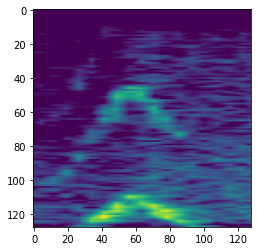

In [15]:
ind = np.random.randint(0, len(melspecs_train))
print(sounds_metadata_train.iloc[ind])
plt.imshow(melspecs_train[ind])